In [65]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance(row):
    coord1 = (row['LATITUDE:'], row['LONGITUDE:'])
    coord2 = (-29.146156, -51.164963)
    return geodesic(coord1, coord2).kilometers

df = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

df["Distancia"] = df.apply(calculate_distance, axis=1) 

df_lower_distance = df.nsmallest(1, 'Distancia')

print(df_lower_distance)



    REGIAO: UF:         ESTACAO: CODIGO (WMO):  LATITUDE:  LONGITUDE:  \
375       S  RS  BENTO GONCALVES          A840 -29.164581  -51.534202   

     ALTITUDE:                                            Arquivo  Distancia  
375     623.27  INMET_S_RS_A840_BENTO GONCALVES_01-01-2023_A_3...  35.982296  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data                                                   8760 non-null   string 
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       8427 non-null   float64
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  8547 non-null   float64
 3   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        8545 non-null   float64
 4   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       8545 non-null   float64
 5   RADIACAO GLOBAL (Kj/m²)                                4744 non-null   float64
 6   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           8547 non-null   float64
 7   TEMPERATURA DO PONTO DE ORVALHO (°C)                   8547 non-null   float64
 8   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)      

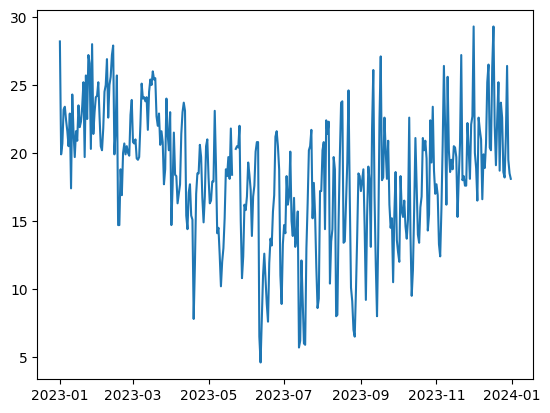

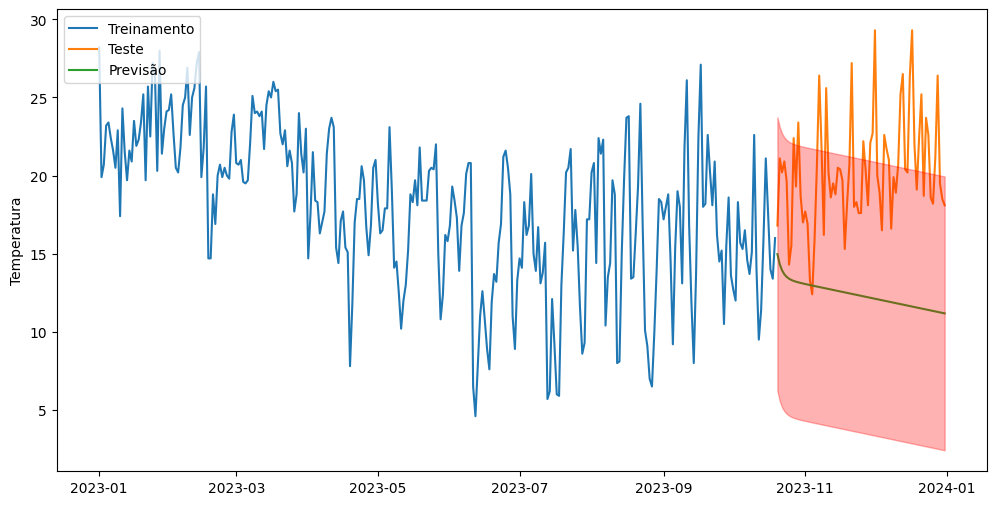

In [66]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

filename = df_lower_distance.iloc[0]['Arquivo']

df_notimecollumn = pd.read_csv(f'../data/2023_cleaned/{filename}', decimal=".", sep=";")

#mudando tipo para string
df_notimecollumn[['Data', 'Hora UTC']] = df_notimecollumn[['Data', 'Hora UTC']].astype("string")

df_notimecollumn = df_notimecollumn.drop(columns=['Hora UTC'])


column_name = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# print(df_notimecollumn.info())
# print(df_notimecollumn.info())
#df_notimecollumn.groupby(['Data'], as_index= True).mean()

print(df_notimecollumn.info())

#Converte Data
df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
df_notimecollumn.set_index('Data', inplace=True)
df_notimecollumn = df_notimecollumn.resample("D").last()

print(df_notimecollumn)


#Teste
plt.plot(df_notimecollumn[column_name], label='Previsão')
plt.savefig('data.png')

# Verificar se há valores nulos
print(df_notimecollumn.isnull().sum())

# Tratar valores nulos
df_notimecollumn = df_notimecollumn.ffill()

# Divisão dos dados em treinamento (80%) e teste (20%)
train_size = int(len(df_notimecollumn) * 0.8)
train, test = df_notimecollumn[:train_size], df_notimecollumn[train_size:]

# Ajuste do modelo ARIMA
model = ARIMA(train[column_name], order=(1, 0, 0), trend='ct')
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test))

# Visualização das previsões
plt.figure(figsize=(12,6))
plt.plot(train.index, train[column_name], label='Treinamento')
plt.plot(test.index, test[column_name], label='Teste')
plt.plot(test.index, forecast, label='Previsão')
plt.ylabel('Temperatura')
plt.legend(loc='upper left')

# Cálculo erro quadrático
mse = mean_squared_error(test[column_name], forecast)
rmse = mse**0.5 
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
plt.fill_between(test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

# Salva o gráfico como arquivo de imagem
plt.savefig('forecast.png')





    
